코드참고 : https://keras.io/examples/keras_recipes/tfrecord/

In [1]:
import tensorflow as tf
import numpy as np
from functools import partial
import pandas as pd

In [47]:
from tensorflow.keras import datasets, layers, models
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D
from keras import optimizers

In [3]:
import IPython.display as display
import matplotlib.pyplot as plt

### 불러오기

In [4]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, IMAGE_SIZE) 
    return image

In [5]:
def read_tfrecord(example, labeled):
    tfrecord_format = (
        {
    'image_raw': tf.io.FixedLenFeature([], tf.string), #data structure of TFRecord
    'landmark_id' : tf.io.FixedLenFeature([], tf.int64),
    'id' : tf.io.FixedLenFeature([], tf.string),
        }
        if labeled
        else {"image": tf.io.FixedLenFeature([], tf.string),}
    )
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example["image_raw"])
    if labeled:
        label = tf.cast(example["landmark_id"], tf.int32)
        return image, label
    return image

In [7]:
def load_dataset(filenames, labeled=True):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False  # disable order, increase speed
    dataset = tf.data.TFRecordDataset(
        filenames
    )  # automatically interleaves reads from multiple files
    dataset = dataset.with_options(
        ignore_order
    )  # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(
        partial(read_tfrecord, labeled=labeled), num_parallel_calls=AUTOTUNE
    )
    # returns a dataset of (image, label) pairs if labeled=True or just images if labeled=False
    return dataset

In [8]:
def get_dataset(filenames, labeled=True):
    dataset = load_dataset(filenames, labeled=labeled)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

In [ ]:
# def make_model():
#     base_model = tf.keras.applications.Xception(
#         input_shape=(*IMAGE_SIZE, 3), include_top=False, weights="imagenet"
#     )

#     base_model.trainable = False

#     inputs = tf.keras.layers.Input([*IMAGE_SIZE, 3])
#     x = tf.keras.applications.xception.preprocess_input(inputs)
#     x = base_model(x)
#     x = tf.keras.layers.GlobalAveragePooling2D()(x)
#     x = tf.keras.layers.Dense(8, activation="relu")(x)
#     x = tf.keras.layers.Dropout(0.7)(x)
#     outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

#     model = tf.keras.Model(inputs=inputs, outputs=outputs)

#     model.compile(
#         optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
#         loss="binary_crossentropy",
#         metrics=tf.keras.metrics.AUC(name="auc"),
#     )

#     return model

In [91]:
def make_model(outN):
    model = tf.keras.models.Sequential()
    model.add(Conv2D(input_shape = (*IMAGE_SIZE,3), filters = 20, kernel_size = (3,3), strides = (1,1), padding = 'same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))

    # prior layer should be flattend to be connected to dense layers
    model.add(Flatten())
    # dense layer with 50 neurons
    model.add(layers.Dense(50, activation = 'relu'))
    # final layer with 10 neurons to classify the instances
    model.add(layers.Dense(outN, activation = 'softmax')) #label의 개수
#    sgd = optimizers.SGD(lr=0.001)
    model.compile(optimizer='adam',
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy'])
    return model

In [92]:
BATCH_SIZE = 32
AUTOTUNE=3  #한번의 배치사이즈 학습동안 다음데이터를 얼마나 불러올 것인지
IMAGE_SIZE = [256, 256]

In [11]:
FILENAMES = tf.io.gfile.glob('./trainset_/*')

In [12]:
uniqueFiles = ['_'.join(x.split('_')[1:-1]) for x in FILENAMES]
uniqueFiles = list(set(uniqueFiles))

In [13]:
outN = len(uniqueFiles) #총 몇개의 label이 있는지
outN

12

In [14]:
def plotting(uF, rows=3, cols=3):
    plotFileNames = [x for x in FILENAMES if uF in x][:rows*cols]

    plotFileNames = get_dataset(plotFileNames)

    plotFileNames = next(iter(plotFileNames))[0]

    plotFiles = [x.numpy().astype(int) for x in plotFileNames]

    fig = plt.figure(figsize=(12,12)) # rows*cols 행렬의 i번째 subplot 생성
    
    i = 1
    xlabels = ["xlabel", "(a)", "(b)", "(c)", "(d)"]

    for p in plotFiles:
        ax = fig.add_subplot(rows, cols, i)
        ax.imshow(p)

        i += 1

    plt.show()

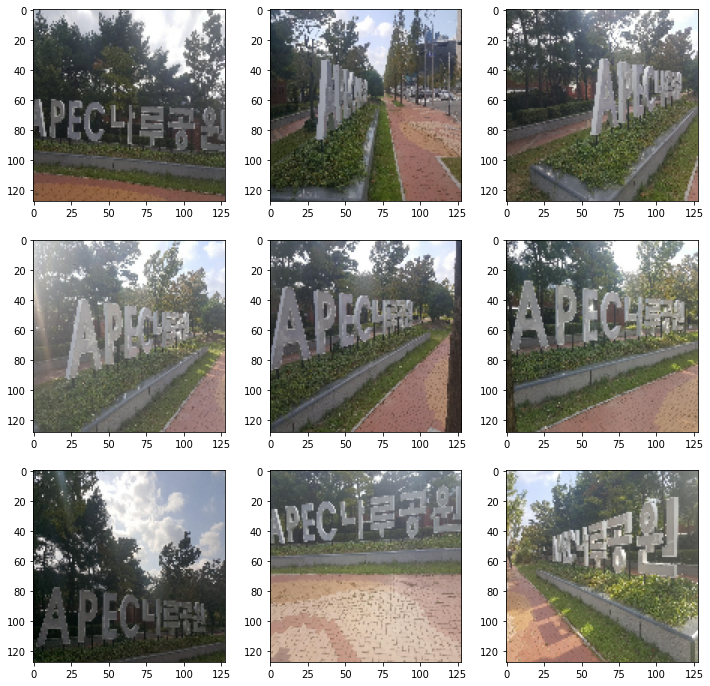

In [17]:
plotting(uniqueFiles[0])

In [22]:
firstEpoch = next(iter(get_dataset(FILENAMES)))

In [27]:
firstEpoch[0].shape

TensorShape([64, 128, 128, 3])

In [53]:
np.random.shuffle(FILENAMES)

In [58]:
train_fn = FILENAMES[:800]
test_fn = FILENAMES[800:]

In [93]:
train = get_dataset(train_fn)
test = get_dataset(test_fn)
model = make_model(outN)
model.fit(train, epochs = 5)

Epoch 1/5
25/25 [==============================] - 30s 1s/step - loss: 91.4049 - accuracy: 0.1562
Epoch 2/5
25/25 [==============================] - 30s 1s/step - loss: 1.4476 - accuracy: 0.5813
Epoch 3/5
25/25 [==============================] - 30s 1s/step - loss: 0.5247 - accuracy: 0.8687
Epoch 4/5
25/25 [==============================] - 30s 1s/step - loss: 0.3246 - accuracy: 0.9300
Epoch 5/5
25/25 [==============================] - 30s 1s/step - loss: 0.0804 - accuracy: 0.9837


In [101]:
pred = model.predict(test)
real = np.array([])
predIdx = np.array([np.argmax(x) for x in pred])
for t in test:
    real = np.append(real, t[1])
print("accuracy : ", np.mean(real.astype(int) == predIdx))

accuracy :  0.28
